In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

In [2]:
#helper functions to calculate proportions at a given timestamp
def calculate_proportions(df):
    if df.empty:
        print("Warning: DataFrame is empty in calculate_proportions")
        return pd.DataFrame(columns=['Category', 'Proportion'])
    
    # Calculate proportions
    proportions = df['alc_use_status'].value_counts(normalize=True).reindex([0, 1, 2, 3], fill_value=0).reset_index()
    proportions.columns = ['Category', 'Proportion']
    
    # Map category labels
    proportions['Category'] = proportions['Category'].map({0: 'Non-Drinking', 1: 'Cat I', 2: 'Cat II', 3: 'Cat III'})
    
    return proportions

def summary_after_release(days, agent_dt):
    filter_condition = (agent_dt['last_release_tick'] > 0) & (agent_dt['tick'] <= agent_dt['last_release_tick'] + days)
    agents_within_period = agent_dt[filter_condition]
    proportions = calculate_proportions(agents_within_period)
    print(f"Summary for {days} days after release:\n", proportions)
    return proportions

def calculate_proportions_smoking(df):
    proportions = df['smoking_status'].value_counts(normalize=True).reset_index()
    proportions.columns = ['Category', 'Proportion']
    proportions['Category'] = pd.Categorical(proportions['Category'], categories=["Never", "Former", "Current"])
    proportions = proportions.sort_values('Category').reset_index(drop=True)
    return proportions

def summary_after_release_smoking(days, agent_dt, ):
    filter_condition = (agent_dt['last_release_tick'] > 0) & (agent_dt['tick'] - agent_dt['last_release_tick'] <= days)
    agents_within_period = agent_dt[filter_condition]
    proportions = calculate_proportions_smoking(agents_within_period)
    agent_count = len(agents_within_period)
    return {'proportions': proportions, 'agent_count': agent_count}



In [6]:
#loading files and checking load
with open("/Users/ryaneng/Desktop/browncs/sph_lab/cadre/python/myparams/model_params.yaml", 'r') as stream:
    input_params = yaml.safe_load(stream)

# Load the agent log environment CSV file
agent_log_env = pd.read_csv("/Users/ryaneng/Desktop/browncs/sph_lab/cadre/python/output_20240702_204607/agent_log.csv")

agent_dt = agent_log_env

# Verify the data is loaded correctly
agent_dt.head()


,tick,id,age,race,female,alc_use_status,smoking_status,last_incarceration_tick,last_release_tick,current_incarceration_status,entry_at_tick,exit_at_tick,n_incarcerations,n_releases,n_smkg_stat_trans,n_alc_use_stat_trans
0,1,0,83,Hispanic,1,1,Former,-1,-1,0,0,-1,0,0,0,0
1,1,1,83,Hispanic,0,3,Former,-1,-1,0,0,-1,0,0,0,0
2,1,2,41,White,1,0,Never,-1,-1,0,0,-1,0,0,0,0
3,1,3,31,Hispanic,0,0,Never,-1,-1,0,0,-1,0,0,0,0
4,1,4,23,White,1,0,Never,-1,-1,0,0,-1,0,0,0,0


In [5]:
print("Columns:\n", agent_dt.columns)

Columns:
 Index(['tick', 'id', 'age', 'race', 'female', 'alc_use_status',
       'smoking_status', 'last_incarceration_tick', 'last_release_tick',
       'current_incarceration_status', 'entry_at_tick', 'exit_at_tick',
       'n_incarcerations', 'n_releases', 'n_smkg_stat_trans',
       'n_alc_use_stat_trans'],
      dtype='object')


In [7]:
#Taking final data after run
selected_ticks = list(range(1, agent_dt["tick"].max() + 1, 10))
last_tick = agent_dt["tick"].max()
print("Selected ticks:", selected_ticks)
print("Last tick:", last_tick)

Selected ticks: [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381, 391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 501, 511, 521, 531, 541, 551, 561, 571, 581, 591, 601, 611, 621, 631, 641, 651, 661, 671, 681, 691, 701, 711, 721, 731, 741, 751, 761, 771, 781, 791, 801, 811, 821, 831, 841, 851, 861, 871, 881, 891, 901, 911, 921, 931, 941, 951, 961, 971, 981, 991, 1001, 1011, 1021, 1031, 1041, 1051, 1061, 1071, 1081, 1091, 1101, 1111, 1121, 1131, 1141, 1151, 1161, 1171, 1181, 1191, 1201, 1211, 1221, 1231, 1241, 1251, 1261, 1271, 1281, 1291, 1301, 1311, 1321, 1331, 1341, 1351, 1361, 1371, 1381, 1391, 1401, 1411, 1421, 1431, 1441, 1451, 1461, 1471, 1481, 1491, 1501, 1511, 1521, 1531, 1541, 1551, 1561, 1571, 1581, 1591, 1601, 1611, 1621, 1631, 1641, 1651, 1661, 1671, 1681, 1691, 1701, 1711, 1721, 1731, 1741, 1751, 1761, 1771, 1781, 1791, 1801, 1811, 18

In [8]:
# Population subsets by release status
desired_tick = last_tick
all_agents = agent_dt[agent_dt["tick"] == desired_tick]
never_released_agents = agent_dt[(agent_dt["tick"] == desired_tick) & (agent_dt["n_releases"] == 0)]
released_agents = agent_dt[(agent_dt["tick"] == desired_tick) & (agent_dt["n_releases"] >= 1)]

# Verify subsets
print("All agents count:", len(all_agents))
print("Never released agents count:", len(never_released_agents))
print("Released agents count:", len(released_agents))

All agents count: 10002
Never released agents count: 9570
Released agents count: 432


## Alcohol Analysis

In [9]:
# Alcohol use state distributions in above subsets
all_agents_summary = calculate_proportions(all_agents)
never_released_agents_summary = calculate_proportions(never_released_agents)
released_agents_summary = calculate_proportions(released_agents)

print("All agents summary:\n", all_agents_summary)
print("Never released agents summary:\n", never_released_agents_summary)
print("Released agents summary:\n", released_agents_summary)

All agents summary:
        Category  Proportion
0  Non-Drinking    0.349530
1         Cat I    0.553489
2        Cat II    0.047790
3       Cat III    0.049190
Never released agents summary:
        Category  Proportion
0  Non-Drinking    0.352456
1         Cat I    0.558516
2        Cat II    0.047231
3       Cat III    0.041797
Released agents summary:
        Category  Proportion
0  Non-Drinking    0.284722
1         Cat I    0.442130
2        Cat II    0.060185
3       Cat III    0.212963


In [10]:
# Summarize alcohol use rates in general population
alcohol_summaries = []
for tick in selected_ticks:
    agents_at_tick = agent_dt[agent_dt["tick"] == tick]
    proportions = calculate_proportions(agents_at_tick)
    alcohol_summaries.append({"proportions": proportions, "tick": tick})

alcohol_proportions_df = pd.concat([pd.DataFrame(s["proportions"]).assign(Tick=s["tick"]) for s in alcohol_summaries])
print("Alcohol proportions DataFrame:\n", alcohol_proportions_df)

Alcohol proportions DataFrame:
         Category  Proportion   Tick
0   Non-Drinking    0.351930      1
1          Cat I    0.552589      1
2         Cat II    0.047291      1
3        Cat III    0.048190      1
0   Non-Drinking    0.351900     11
..           ...         ...    ...
3        Cat III    0.049185  10931
0   Non-Drinking    0.349430  10941
1          Cat I    0.553589  10941
2         Cat II    0.047790  10941
3        Cat III    0.049190  10941

[4380 rows x 3 columns]


In [12]:
#Calculating proportions after 1 year (using helper functions)
fixed_time_after_release = 365
within_fixed_time_after_release_agents = agent_dt[(agent_dt["last_release_tick"] > 0) & (agent_dt["tick"] <= agent_dt["last_release_tick"] + fixed_time_after_release)]
within_fixed_time_after_release_summary = calculate_proportions(within_fixed_time_after_release_agents)

print("Summary for Agents Within One Year After Release")
print(within_fixed_time_after_release_summary)

# Sensitivity Analysis on parameter of time after release
time_periods = [1, 7, 14, 30, 90, 180, 365]
summaries = [summary_after_release(days, agent_dt) for days in time_periods]

Summary for Agents Within One Year After Release
       Category  Proportion
0  Non-Drinking    0.269205
1         Cat I    0.367635
2        Cat II    0.031544
3       Cat III    0.331616
Summary for 1 days after release:
        Category  Proportion
0  Non-Drinking       0.260
1         Cat I       0.376
2        Cat II       0.012
3       Cat III       0.352
Summary for 7 days after release:
        Category  Proportion
0  Non-Drinking    0.251317
1         Cat I    0.355907
2        Cat II    0.024831
3       Cat III    0.367946
Summary for 14 days after release:
        Category  Proportion
0  Non-Drinking    0.256651
1         Cat I    0.348200
2        Cat II    0.028169
3       Cat III    0.366980
Summary for 30 days after release:
        Category  Proportion
0  Non-Drinking    0.257937
1         Cat I    0.344730
2        Cat II    0.028743
3       Cat III    0.368589
Summary for 90 days after release:
        Category  Proportion
0  Non-Drinking    0.260374
1         Cat I  

In [13]:
# Organizing data to plot heavy drinking/AUD after release
labels = ["1D", "1W", "2W", "1M", "3M", "6M", "1Y"]
heavy_use_or_AUD_proportions = [s.loc[s["Category"] == "Cat III", "Proportion"].sum() if "Cat III" in s["Category"].values else 0 for s in summaries]

heavy_use_AUD_df = pd.DataFrame({
    "Time": time_periods,
    "Labels": labels,
    "Proportion": heavy_use_or_AUD_proportions
})

print("Heavy use AUD DataFrame:\n", heavy_use_AUD_df)

Heavy use AUD DataFrame:
    Time Labels  Proportion
0     1     1D    0.352000
1     7     1W    0.367946
2    14     2W    0.366980
3    30     1M    0.368589
4    90     3M    0.361594
5   180     6M    0.351563
6   365     1Y    0.331616


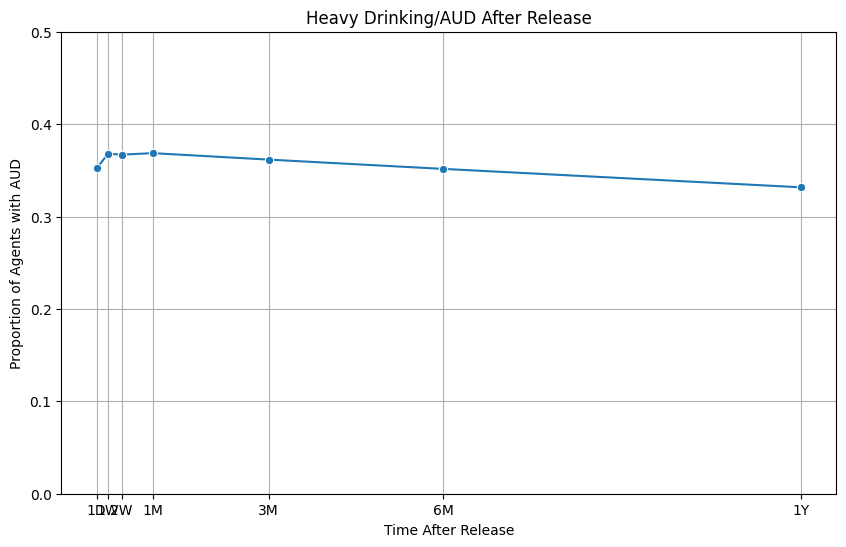

In [14]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=heavy_use_AUD_df, x="Time", y="Proportion", marker="o")
plt.xticks(ticks=time_periods, labels=labels)
plt.yticks(np.arange(0, 0.6, 0.1))
plt.xlabel("Time After Release")
plt.ylabel("Proportion of Agents with AUD")
plt.title("Heavy Drinking/AUD After Release")
plt.ylim(0, 0.5)
plt.grid(True)
plt.show()

In [15]:
# Compare Heavy Use/AUD in general population with the post-release group
general_heavy_AUD_df = alcohol_proportions_df[alcohol_proportions_df["Category"] == "Cat III"]
combined_proportions = general_heavy_AUD_df.groupby("Tick").sum().reset_index()
last_combined_rate = combined_proportions.tail(10)["Proportion"].mean()
last_combined_rate_df = pd.DataFrame({
    "Time": range(max(heavy_use_AUD_df["Time"]), 366),
    "Proportion": last_combined_rate
})

general_population = pd.DataFrame({
    "Time": heavy_use_AUD_df["Time"],
    "Proportion": last_combined_rate_df["Proportion"]
})

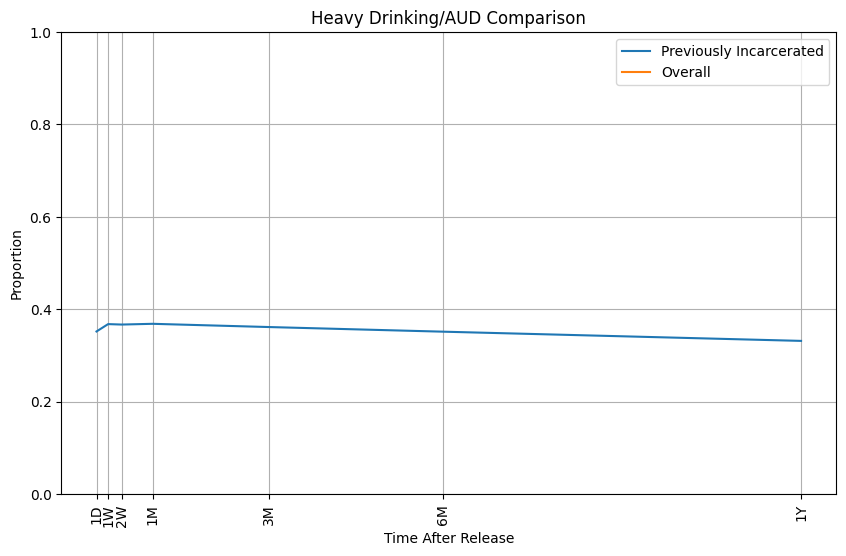

In [16]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=heavy_use_AUD_df, x="Time", y="Proportion", label="Previously Incarcerated", linewidth=1.5)
sns.lineplot(data=general_population, x="Time", y="Proportion", label="Overall", linewidth=1.5)
plt.ylim(0, 1)
plt.xlabel("Time After Release")
plt.ylabel("Proportion")
plt.title("Heavy Drinking/AUD Comparison")
plt.xticks(ticks=heavy_use_AUD_df["Time"], labels=heavy_use_AUD_df["Labels"], rotation=90)
plt.legend()
plt.grid(True)
plt.show()

## Smoking

In [17]:
# Tabulating smoking ratio at last tick of current smoking to all persons
last_tick_data = agent_dt[agent_dt["tick"] == last_tick]
smoking_ratio = last_tick_data.groupby(last_tick_data['n_releases'] >= 1).apply(lambda df: pd.Series({
    'n_current_smokers': (df['smoking_status'] == 'Current').sum(),
    'n_total_persons': df['smoking_status'].isin(['Current', 'Former', 'Never']).sum()
})).reset_index()

In [18]:
# Compute the ratio of current smokers to total smokers in each group
smoking_ratio['ratio'] = smoking_ratio['n_current_smokers'] / smoking_ratio['n_total_persons']
print(smoking_ratio)

# Compute change in current smoking over time since release for given timestamps
#Goal- we want to see what happens immediately after release back into networks
time_periods = [1, 7, 14, 30, 90, 180, 365]
labels = ["1D", "1W", "2W", "1M", "3M", "6M", "1Y"]
summaries_smoking = [summary_after_release_smoking(days, agent_dt) for days in time_periods]

# Visualization (smoking in released persons)
current_smoker_proportions = [
    s['proportions'].loc[s['proportions']['Category'] == 'Current', 'Proportion'].sum() 
    if 'Category' in s['proportions'].columns and 'Current' in s['proportions']['Category'].values 
    else 0
    for s in summaries_smoking
]

   n_releases  n_current_smokers  n_total_persons     ratio
0       False               1292             9570  0.135005
1        True                148              432  0.342593


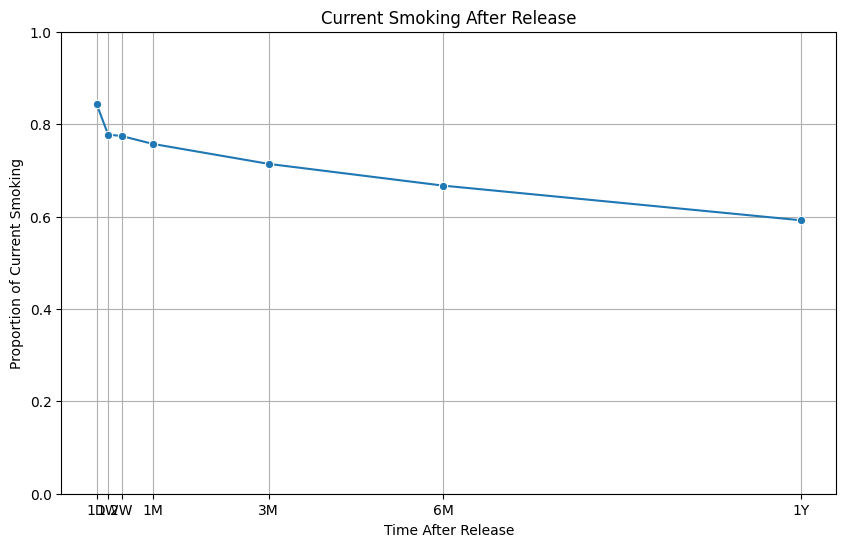

In [19]:
# Visualization (smoking in released persons)
current_smoker_proportions = [
    s['proportions'].loc[s['proportions']['Category'] == 'Current', 'Proportion'].sum() 
    if 'Category' in s['proportions'].columns and 'Current' in s['proportions']['Category'].values 
    else 0
    for s in summaries_smoking
]

current_smoker_df = pd.DataFrame({
    "Time": time_periods,
    "Labels": labels,
    "Proportion": current_smoker_proportions
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=current_smoker_df, x="Time", y="Proportion", marker="o")
plt.xticks(ticks=time_periods, labels=labels)
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel("Time After Release")
plt.ylabel("Proportion of Current Smoking")
plt.title("Current Smoking After Release")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [20]:
# Visualization (smoking in general population)
smokers_by_tick = agent_dt[agent_dt["tick"].isin(selected_ticks)].groupby("tick").apply(
    lambda df: pd.Series({
        'current_smokers': (df['smoking_status'] == 'Current').mean(),
        'former_smokers': (df['smoking_status'] == 'Former').mean(),
        'never_smokers': (df['smoking_status'] == 'Never').mean()
    })
).reset_index()

# Mean from the last 10 rows
mean_current_smoker = smokers_by_tick.tail(10)["current_smokers"].mean()

/var/folders/5w/_sx0pyps50s6zzsjl55lmt340000gn/T/ipykernel_69330/2997918659.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  smokers_by_tick = agent_dt[agent_dt["tick"].isin(selected_ticks)].groupby("tick").apply(


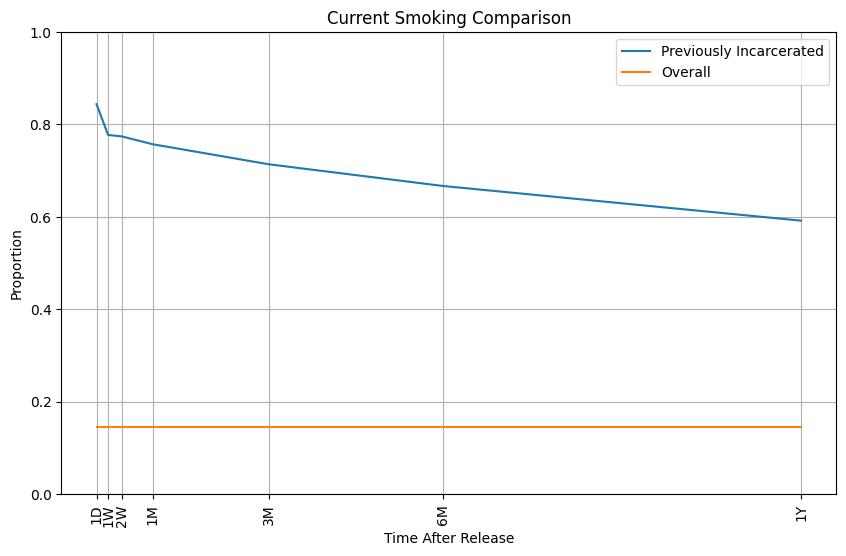

In [21]:
# General population data frame
general_population = pd.DataFrame({
    "Time": current_smoker_df["Time"],
    "Proportion": [mean_current_smoker] * len(current_smoker_df["Time"])
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=current_smoker_df, x="Time", y="Proportion", label="Previously Incarcerated", linewidth=1.5)
sns.lineplot(data=general_population, x="Time", y="Proportion", label="Overall", linewidth=1.5)
plt.ylim(0, 1)
plt.xlabel("Time After Release")
plt.ylabel("Proportion")
plt.title("Current Smoking Comparison")
plt.xticks(ticks=current_smoker_df["Time"], labels=current_smoker_df["Labels"], rotation=90)
plt.legend()
plt.grid(True)
plt.show()